<a href="https://colab.research.google.com/github/alecgarza96/Predicting-NBA-Salaries/blob/main/nba_salaries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing and previewing data

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from datetime import date
from datetime import datetime
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor



filename = '/content/nba2k20-full.csv'

nba_df = pd.read_csv(filename)
print(nba_df.head())
print('\n')
print(nba_df.describe())
print('\n')
print(nba_df.dtypes)

               full_name  rating jersey  ... draft_round draft_peak          college
0           LeBron James      97    #23  ...           1          1              NaN
1          Kawhi Leonard      97     #2  ...           1         15  San Diego State
2  Giannis Antetokounmpo      96    #34  ...           1         15              NaN
3           Kevin Durant      96     #7  ...           1          2            Texas
4           James Harden      96    #13  ...           1          3    Arizona State

[5 rows x 14 columns]


           rating   draft_year
count  429.000000   429.000000
mean    76.372960  2014.093240
std      5.657748     3.937678
min     67.000000  2001.000000
25%     72.000000  2012.000000
50%     75.000000  2015.000000
75%     79.000000  2017.000000
max     97.000000  2019.000000


full_name      object
rating          int64
jersey         object
team           object
position       object
b_day          object
height         object
weight         object
salary  

Converting jersey feature to integer

In [ ]:
nba_df['jersey'] = nba_df['jersey'].str.replace(r'\#','').astype(int)

Reformatting Height (inches), Weight (lbs), and Salary

In [ ]:
nba_df['weight'] = [float(nba_df['weight'][i].split()[0]) for i in range(len(nba_df))]
nba_df['height'] = [float(nba_df['height'][i].split()[-1])*39.3701 for i in range(len(nba_df))]
nba_df['salary'] = [float(nba_df['salary'][i].split('$')[1]) for i in range(len(nba_df))]

Handle Missing Values

In [ ]:
nba_df = nba_df.fillna(0)

Convert Birthday to Age

In [ ]:
nba_df['b_day'] = nba_df['b_day'].apply(lambda x: datetime.strptime(x, '%m/%d/%y').date())
nba_df['age'] = (datetime.today().date() - nba_df['b_day']).astype('<m8[Y]').astype('int64')
nba_df = nba_df.drop(['b_day'], axis=1)

Fix duplicate in positions column

In [ ]:
nba_df['position'] = nba_df['position'].apply(lambda x: 'F-C' if x=='C-F' else x)
nba_df['position'] = nba_df['position'].apply(lambda x: 'F-G' if x == 'G-F' else x)

Changing Draft Round 'Undrafted' value to 3 and converting other values to int

In [ ]:
nba_df['draft_round'] = nba_df['draft_round'].replace('Undrafted','3')

Getting top 20 highest paid players

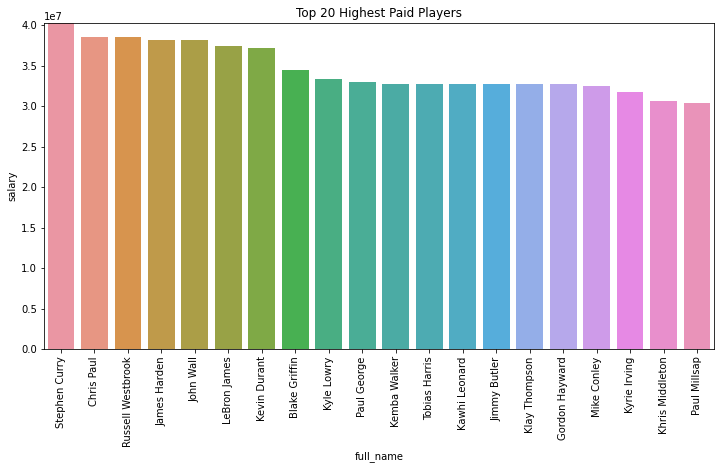

In [ ]:
twentieth_salary = nba_df.nlargest(20,'salary').reset_index().drop('index', axis=1).sort_values('salary', ascending=False)
fig, ax = plt.subplots(figsize=(12,6))
ax.set(ylim=(0, twentieth_salary['salary'].max()))
sns.barplot(x=twentieth_salary['full_name'],y=twentieth_salary['salary'])
plt.xticks(rotation=90)
plt.title("Top 20 Highest Paid Players")
plt.show()

Most Popular Jersey Number

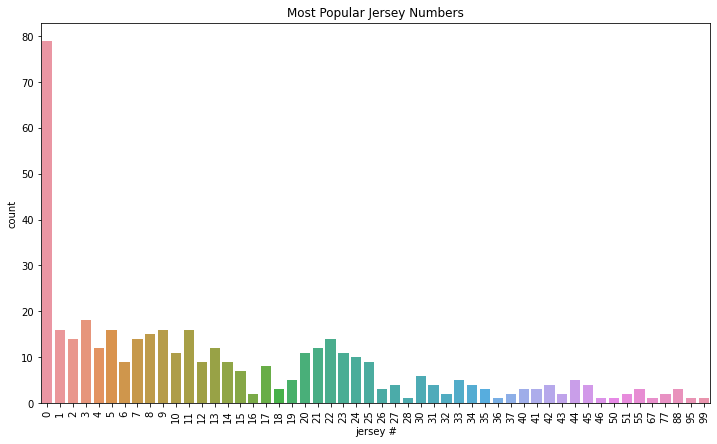

In [ ]:
jersey_counts = nba_df['jersey'].value_counts().reset_index().sort_values('index')
jersey_counts = jersey_counts.rename(columns={"index": 'jersey #', "jersey": 'count'})
jersey_counts = jersey_counts.reset_index().drop('index',axis=1)

fig, ax = plt.subplots(figsize=(12,7))
sns.barplot(x=jersey_counts['jersey #'],y=jersey_counts['count'])
plt.xticks(rotation=90)
plt.title("Most Popular Jersey Numbers")
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


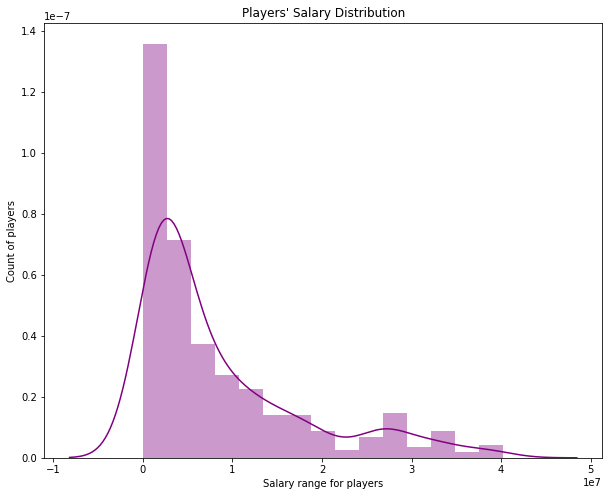

In [ ]:
plt.rcParams['figure.figsize'] = (10, 8)
sns.distplot(nba_df['salary'], color = 'purple')
plt.xlabel('Salary range for players')
plt.ylabel('Count of players')
plt.title('Players\' Salary Distribution')
plt.xticks()
plt.show()

Player Height Distribution


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


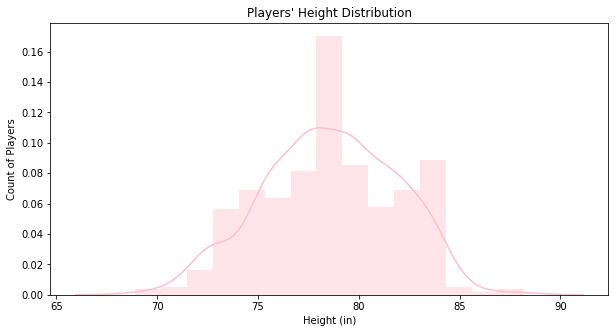

In [ ]:
fig = plt.figure(figsize = (10, 5))
sns.distplot(nba_df.height, color='pink')
plt.xlabel('Height (in)')
plt.ylabel('Count of Players')
plt.title('Players\' Height Distribution')
plt.show()

Player Rating Distribution

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


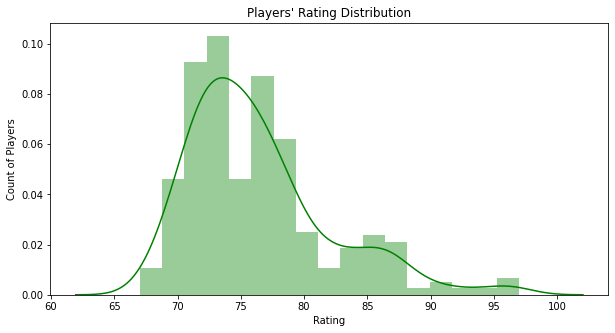

In [ ]:
fig = plt.figure(figsize = (10, 5))
sns.distplot(nba_df.rating, color='green')
plt.xlabel('Rating')
plt.ylabel('Count of Players')
plt.title('Players\' Rating Distribution')
plt.show()

Encoding Strings/Categorical Data

In [ ]:
print(nba_df.dtypes)

full_name       object
rating           int64
jersey           int64
team            object
position        object
height         float64
weight         float64
salary         float64
country         object
draft_year       int64
draft_round      int64
draft_peak       int64
college         object
age              int64
dtype: object


One-Hot Encoding Team Column

In [ ]:
nba_df = nba_df.drop(['full_name','draft_peak','college'],axis=1)
for column in ['team','position','country','draft_round']:
    encoded_columns = pd.get_dummies(nba_df[column])
    nba_df = nba_df.join(encoded_columns).drop(column, axis=1)

In [ ]:
y, X = nba_df['salary'], nba_df.drop('salary', axis=1)
X = preprocessing.normalize(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

regr = MLPRegressor(random_state=0, 
                    hidden_layer_sizes = (64, 64, 64, 120),
                    alpha=0.001,
                    solver='lbfgs',
                    learning_rate='invscaling', learning_rate_init=1e-5,
                    max_iter=10000).fit(X_train, y_train)

y_predict = regr.predict(X_test)

print('Mean squared error: ', np.sqrt(mean_squared_error(y_test, y_predict)))
print('Score: ', (regr.score(X_test, y_test)*100))


Mean squared error:  4540702.902529855
Score:  77.60299738800327
